In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense  ,Dropout
from keras.optimizers import Adam
from sklearn.metrics import r2_score
from tqdm import tqdm
from lazypredict.Supervised import LazyRegressor


# Data

In [18]:
def _load_data():
    train=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Training set 2011-2015')
    train.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)

    test=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Testing set 2016-2019 ')
    test.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)

    print(train.shape,test.shape)
    return train , test

# Prepare

In [3]:
def _prepare_data(data):
    X_train=data.drop(['dissolved_oxygen'],axis=1)
    y_train=data.dissolved_oxygen
    return X_train , y_train

def _scale_data(X_train,y_train):
    X_scaler=StandardScaler()
    X_train_scaled=X_scaler.fit_transform(X_train)
    y_scaler=StandardScaler()
    y_train_scaled=y_scaler.fit_transform(np.array(y_train).reshape(-1,1))
    print(X_train_scaled.shape, y_train_scaled.shape)
    return X_train_scaled,y_train_scaled , X_scaler , y_scaler

def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [4]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)


(605, 10) (605, 1)


# Model


In [ ]:
model = Sequential()
model.add(Dense(10, input_shape=(X_train[0].shape[0],), kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train,epochs=10,batch_size=8)

KerasRegressor(model=model, epochs=100, batch_size=5, verbose=0).fit(X_train, y_train)


we have some missing values here

In [110]:
nonul_train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)
X_train,y_train=_prepare_data(nonul_train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)



(605, 10) (605, 1)


In [117]:
nonul_test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)
X_test,y_test=_prepare_data(nonul_test)

X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))


let's create the model and compile it

In [172]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(X_train[0].shape[0], input_shape=(X_train[0].shape[0],), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2


In [ ]:
history , r2=_compile_model(X_train,y_train,X_test,y_test,80,32)

batch size itrator

In [180]:
r2_all=[]
for item in tqdm([8,16,32,64,128,256,512]):
    history , r2=_compile_model(X_train,y_train,X_test,y_test,80,item)
    r2_all.append(r2)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/80
76/76 [==============================] - 1s 7ms/step - loss: 0.9799 - val_loss: 0.7359
Epoch 2/80
76/76 [==============================] - 0s 5ms/step - loss: 0.9088 - val_loss: 0.6404
Epoch 3/80
76/76 [==============================] - 0s 5ms/step - loss: 0.8070 - val_loss: 0.5552
Epoch 4/80
76/76 [==============================] - 0s 5ms/step - loss: 0.7539 - val_loss: 0.5241
Epoch 5/80
76/76 [==============================] - 0s 6ms/step - loss: 0.7305 - val_loss: 0.5132
Epoch 6/80
76/76 [==============================] - 0s 5ms/step - loss: 0.7200 - val_loss: 0.5101
Epoch 7/80
76/76 [==============================] - 0s 5ms/step - loss: 0.7085 - val_loss: 0.5094
Epoch 8/80
76/76 [==============================] - 0s 5ms/step - loss: 0.7015 - val_loss: 0.5120
Epoch 9/80
76/76 [==============================] - 0s 6ms/step - loss: 0.6972 - val_loss: 0.5161
Epoch 10/80
76/76 [==============================] - 0s 6ms/step - loss: 0.6921 - val_loss: 0.5183
Epoch 11/80
76/76 [

 14%|█▍        | 1/7 [00:25<02:33, 25.61s/it]

Epoch 1/80
38/38 [==============================] - 1s 8ms/step - loss: 0.9808 - val_loss: 0.7415
Epoch 2/80
38/38 [==============================] - 0s 4ms/step - loss: 0.9398 - val_loss: 0.6931
Epoch 3/80
38/38 [==============================] - 0s 4ms/step - loss: 0.8759 - val_loss: 0.6326
Epoch 4/80
38/38 [==============================] - 0s 4ms/step - loss: 0.8170 - val_loss: 0.5860
Epoch 5/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7784 - val_loss: 0.5577
Epoch 6/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7581 - val_loss: 0.5426
Epoch 7/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7415 - val_loss: 0.5330
Epoch 8/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7320 - val_loss: 0.5275
Epoch 9/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7240 - val_loss: 0.5250
Epoch 10/80
38/38 [==============================] - 0s 4ms/step - loss: 0.7163 - val_loss: 0.5229
Epoch 11/80
38/38 [

 29%|██▊       | 2/7 [00:38<01:30, 18.08s/it]

Epoch 1/80
19/19 [==============================] - 1s 12ms/step - loss: 0.9905 - val_loss: 0.7545
Epoch 2/80
19/19 [==============================] - 0s 5ms/step - loss: 0.9711 - val_loss: 0.7318
Epoch 3/80
19/19 [==============================] - 0s 6ms/step - loss: 0.9438 - val_loss: 0.7010
Epoch 4/80
19/19 [==============================] - 0s 5ms/step - loss: 0.9091 - val_loss: 0.6619
Epoch 5/80
19/19 [==============================] - 0s 5ms/step - loss: 0.8672 - val_loss: 0.6235
Epoch 6/80
19/19 [==============================] - 0s 5ms/step - loss: 0.8280 - val_loss: 0.5908
Epoch 7/80
19/19 [==============================] - 0s 5ms/step - loss: 0.7954 - val_loss: 0.5677
Epoch 8/80
19/19 [==============================] - 0s 5ms/step - loss: 0.7736 - val_loss: 0.5496
Epoch 9/80
19/19 [==============================] - 0s 5ms/step - loss: 0.7575 - val_loss: 0.5399
Epoch 10/80
19/19 [==============================] - 0s 5ms/step - loss: 0.7466 - val_loss: 0.5300
Epoch 11/80
19/19 

 43%|████▎     | 3/7 [00:47<00:55, 13.77s/it]

Epoch 1/80
10/10 [==============================] - 1s 21ms/step - loss: 0.9821 - val_loss: 0.7479
Epoch 2/80
10/10 [==============================] - 0s 7ms/step - loss: 0.9699 - val_loss: 0.7359
Epoch 3/80
10/10 [==============================] - 0s 8ms/step - loss: 0.9566 - val_loss: 0.7218
Epoch 4/80
10/10 [==============================] - 0s 7ms/step - loss: 0.9412 - val_loss: 0.7055
Epoch 5/80
10/10 [==============================] - 0s 8ms/step - loss: 0.9231 - val_loss: 0.6877
Epoch 6/80
10/10 [==============================] - 0s 8ms/step - loss: 0.9031 - val_loss: 0.6685
Epoch 7/80
10/10 [==============================] - 0s 8ms/step - loss: 0.8835 - val_loss: 0.6474
Epoch 8/80
10/10 [==============================] - 0s 8ms/step - loss: 0.8618 - val_loss: 0.6267
Epoch 9/80
10/10 [==============================] - 0s 7ms/step - loss: 0.8406 - val_loss: 0.6080
Epoch 10/80
10/10 [==============================] - 0s 7ms/step - loss: 0.8212 - val_loss: 0.5910
Epoch 11/80
10/10 

 57%|█████▋    | 4/7 [00:58<00:38, 12.71s/it]

Epoch 1/80
5/5 [==============================] - 1s 43ms/step - loss: 0.9982 - val_loss: 0.7683
Epoch 2/80
5/5 [==============================] - 0s 11ms/step - loss: 0.9938 - val_loss: 0.7645
Epoch 3/80
5/5 [==============================] - 0s 11ms/step - loss: 0.9896 - val_loss: 0.7601
Epoch 4/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9847 - val_loss: 0.7551
Epoch 5/80
5/5 [==============================] - 0s 14ms/step - loss: 0.9794 - val_loss: 0.7492
Epoch 6/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9729 - val_loss: 0.7424
Epoch 7/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9653 - val_loss: 0.7346
Epoch 8/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9561 - val_loss: 0.7258
Epoch 9/80
5/5 [==============================] - 0s 10ms/step - loss: 0.9464 - val_loss: 0.7157
Epoch 10/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9351 - val_loss: 0.7046
Epoch 11/80
5/5 [============

 71%|███████▏  | 5/7 [01:03<00:20, 10.24s/it]

Epoch 1/80
3/3 [==============================] - 1s 102ms/step - loss: 0.9990 - val_loss: 0.7723
Epoch 2/80
3/3 [==============================] - 0s 25ms/step - loss: 0.9963 - val_loss: 0.7700
Epoch 3/80
3/3 [==============================] - 0s 28ms/step - loss: 0.9937 - val_loss: 0.7679
Epoch 4/80
3/3 [==============================] - 0s 33ms/step - loss: 0.9912 - val_loss: 0.7656
Epoch 5/80
3/3 [==============================] - 0s 28ms/step - loss: 0.9888 - val_loss: 0.7633
Epoch 6/80
3/3 [==============================] - 0s 26ms/step - loss: 0.9861 - val_loss: 0.7609
Epoch 7/80
3/3 [==============================] - 0s 26ms/step - loss: 0.9835 - val_loss: 0.7583
Epoch 8/80
3/3 [==============================] - 0s 29ms/step - loss: 0.9807 - val_loss: 0.7555
Epoch 9/80
3/3 [==============================] - 0s 35ms/step - loss: 0.9775 - val_loss: 0.7524
Epoch 10/80
3/3 [==============================] - 0s 32ms/step - loss: 0.9739 - val_loss: 0.7489
Epoch 11/80
3/3 [===========

 86%|████████▌ | 6/7 [01:10<00:09,  9.03s/it]

Epoch 1/80
2/2 [==============================] - 1s 197ms/step - loss: 0.9992 - val_loss: 0.7777
Epoch 2/80
2/2 [==============================] - 0s 55ms/step - loss: 0.9973 - val_loss: 0.7762
Epoch 3/80
2/2 [==============================] - 0s 57ms/step - loss: 0.9955 - val_loss: 0.7747
Epoch 4/80
2/2 [==============================] - 0s 53ms/step - loss: 0.9938 - val_loss: 0.7733
Epoch 5/80
2/2 [==============================] - 0s 53ms/step - loss: 0.9921 - val_loss: 0.7719
Epoch 6/80
2/2 [==============================] - 0s 66ms/step - loss: 0.9904 - val_loss: 0.7704
Epoch 7/80
2/2 [==============================] - 0s 60ms/step - loss: 0.9886 - val_loss: 0.7689
Epoch 8/80
2/2 [==============================] - 0s 58ms/step - loss: 0.9868 - val_loss: 0.7674
Epoch 9/80
2/2 [==============================] - 0s 48ms/step - loss: 0.9849 - val_loss: 0.7658
Epoch 10/80
2/2 [==============================] - 0s 58ms/step - loss: 0.9829 - val_loss: 0.7641
Epoch 11/80
2/2 [===========

100%|██████████| 7/7 [01:17<00:00, 11.02s/it]


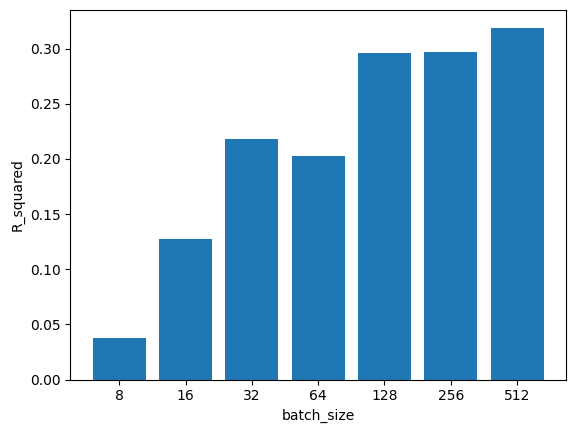

In [188]:
plt.bar(range(7),r2_all)
plt.xticks(range(7),[8,16,32,64,128,256,512])
plt.xlabel('batch_size')
plt.ylabel('R_squared')
plt.show()

epochs

In [191]:
# r2_all=[]
for item in tqdm(range(150,200,10)):
    history , r2=_compile_model(X_train,y_train,X_test,y_test,item,8)
    r2_all.append(r2)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/150
76/76 [==============================] - 2s 10ms/step - loss: 0.9837 - val_loss: 0.7372
Epoch 2/150
76/76 [==============================] - 0s 4ms/step - loss: 0.9113 - val_loss: 0.6397
Epoch 3/150
76/76 [==============================] - 0s 3ms/step - loss: 0.8040 - val_loss: 0.5580
Epoch 4/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7648 - val_loss: 0.5265
Epoch 5/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7454 - val_loss: 0.5178
Epoch 6/150
76/76 [==============================] - 0s 4ms/step - loss: 0.7327 - val_loss: 0.5125
Epoch 7/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7259 - val_loss: 0.5091
Epoch 8/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7218 - val_loss: 0.5103
Epoch 9/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7142 - val_loss: 0.5089
Epoch 10/150
76/76 [==============================] - 0s 3ms/step - loss: 0.7095 - val_loss: 0.5105
Epoch 11

 20%|██        | 1/5 [00:39<02:39, 39.89s/it]

Epoch 1/160
76/76 [==============================] - 1s 5ms/step - loss: 0.9687 - val_loss: 0.7145
Epoch 2/160
76/76 [==============================] - 0s 3ms/step - loss: 0.8932 - val_loss: 0.6228
Epoch 3/160
76/76 [==============================] - 0s 3ms/step - loss: 0.8119 - val_loss: 0.5546
Epoch 4/160
76/76 [==============================] - 0s 3ms/step - loss: 0.7557 - val_loss: 0.5183
Epoch 5/160
76/76 [==============================] - 0s 3ms/step - loss: 0.7308 - val_loss: 0.5040
Epoch 6/160
76/76 [==============================] - 0s 4ms/step - loss: 0.7170 - val_loss: 0.5032
Epoch 7/160
76/76 [==============================] - 0s 3ms/step - loss: 0.7091 - val_loss: 0.5033
Epoch 8/160
76/76 [==============================] - 0s 4ms/step - loss: 0.7029 - val_loss: 0.5075
Epoch 9/160
76/76 [==============================] - 0s 3ms/step - loss: 0.6974 - val_loss: 0.5114
Epoch 10/160
76/76 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.5145
Epoch 11/

 40%|████      | 2/5 [01:27<02:13, 44.41s/it]

Epoch 1/170
76/76 [==============================] - 1s 6ms/step - loss: 0.9785 - val_loss: 0.7254
Epoch 2/170
76/76 [==============================] - 0s 4ms/step - loss: 0.8835 - val_loss: 0.6215
Epoch 3/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7971 - val_loss: 0.5613
Epoch 4/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7575 - val_loss: 0.5341
Epoch 5/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7379 - val_loss: 0.5211
Epoch 6/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7267 - val_loss: 0.5161
Epoch 7/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7206 - val_loss: 0.5103
Epoch 8/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7129 - val_loss: 0.5137
Epoch 9/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7081 - val_loss: 0.5145
Epoch 10/170
76/76 [==============================] - 0s 4ms/step - loss: 0.7015 - val_loss: 0.5145
Epoch 11/

 60%|██████    | 3/5 [02:26<01:42, 51.07s/it]

Epoch 1/180
76/76 [==============================] - 1s 6ms/step - loss: 0.9952 - val_loss: 0.7502
Epoch 2/180
76/76 [==============================] - 0s 4ms/step - loss: 0.9221 - val_loss: 0.6498
Epoch 3/180
76/76 [==============================] - 0s 4ms/step - loss: 0.8188 - val_loss: 0.5614
Epoch 4/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7630 - val_loss: 0.5248
Epoch 5/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7413 - val_loss: 0.5118
Epoch 6/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7256 - val_loss: 0.5067
Epoch 7/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7182 - val_loss: 0.5046
Epoch 8/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7073 - val_loss: 0.5044
Epoch 9/180
76/76 [==============================] - 0s 4ms/step - loss: 0.7012 - val_loss: 0.5060
Epoch 10/180
76/76 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.5049
Epoch 11/

 80%|████████  | 4/5 [03:29<00:55, 55.96s/it]

Epoch 1/190
76/76 [==============================] - 1s 6ms/step - loss: 0.9806 - val_loss: 0.7254
Epoch 2/190
76/76 [==============================] - 0s 4ms/step - loss: 0.8891 - val_loss: 0.6159
Epoch 3/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7922 - val_loss: 0.5470
Epoch 4/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7517 - val_loss: 0.5243
Epoch 5/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7351 - val_loss: 0.5167
Epoch 6/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7220 - val_loss: 0.5139
Epoch 7/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7162 - val_loss: 0.5130
Epoch 8/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7099 - val_loss: 0.5154
Epoch 9/190
76/76 [==============================] - 0s 4ms/step - loss: 0.7039 - val_loss: 0.5161
Epoch 10/190
76/76 [==============================] - 0s 4ms/step - loss: 0.6994 - val_loss: 0.5207
Epoch 11/

100%|██████████| 5/5 [04:37<00:00, 55.44s/it]


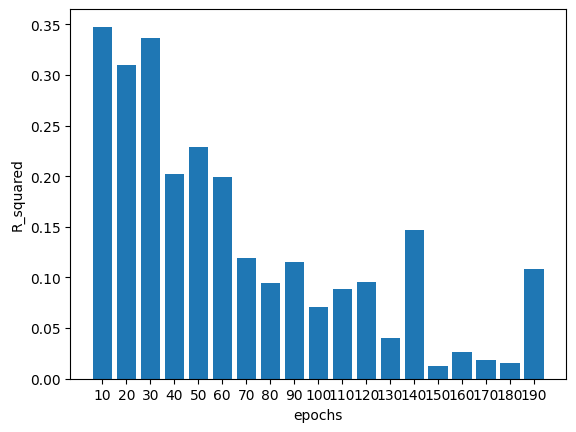

In [192]:
plt.bar(range(len(r2_all)),r2_all)
plt.xticks(range(len(r2_all)),range(10,200,10))
plt.xlabel('epochs')
plt.ylabel('R_squared')
plt.show()

# The best we have

In [210]:
x=X_test[:100,:]
y=y_test[:100,:]

In [211]:
history , r2=_compile_model(X_train,y_train,x,y,100,8)

Epoch 1/150
76/76 [==============================] - 2s 10ms/step - loss: 0.9840 - val_loss: 0.2815
Epoch 2/150
76/76 [==============================] - 1s 7ms/step - loss: 0.9100 - val_loss: 0.2042
Epoch 3/150
76/76 [==============================] - 1s 7ms/step - loss: 0.8204 - val_loss: 0.1540
Epoch 4/150
76/76 [==============================] - 1s 7ms/step - loss: 0.7760 - val_loss: 0.1297
Epoch 5/150
76/76 [==============================] - 1s 7ms/step - loss: 0.7493 - val_loss: 0.1274
Epoch 6/150
76/76 [==============================] - 0s 6ms/step - loss: 0.7382 - val_loss: 0.1291
Epoch 7/150
76/76 [==============================] - 0s 6ms/step - loss: 0.7307 - val_loss: 0.1315
Epoch 8/150
76/76 [==============================] - 1s 7ms/step - loss: 0.7220 - val_loss: 0.1345
Epoch 9/150
76/76 [==============================] - 1s 7ms/step - loss: 0.7178 - val_loss: 0.1373
Epoch 10/150
76/76 [==============================] - 1s 7ms/step - loss: 0.7148 - val_loss: 0.1477
Epoch 11

In [212]:
r2

-1.084627874795956

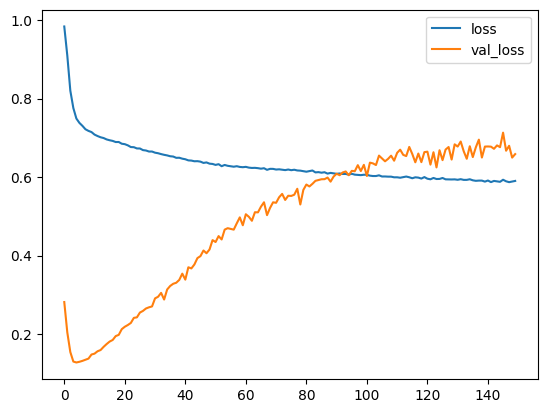

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

# It's overfitted. needs to be fixed

In [134]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()

# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(605, 10) (605, 1)


In [10]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(X_train[0].shape[0], input_shape=(X_train[0].shape[0],), activation='relu'))
    model.add(Dense(1))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred
history , r2 , y_pred=_compile_model(X_train,y_train,X_test,y_test,50,16)

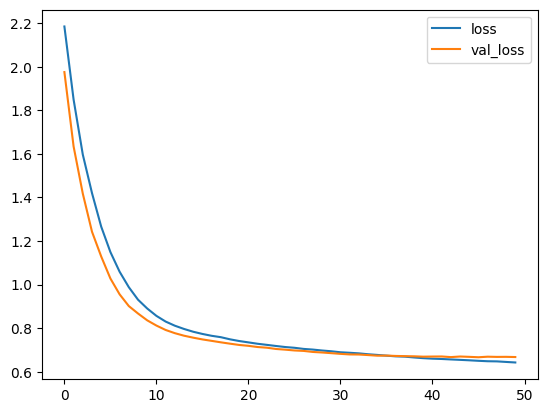

0.3327725349312406

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
r2

I missunderstood the entire R_squared formula 

In [54]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(25, input_shape=(X_train[0].shape[0],),kernel_initializer='normal', activation='relu'))
    model.add(Dense(12,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,kernel_initializer='normal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred
history , r2 , y_pred=_compile_model(X_train,y_train,X_test,y_test,50,4)

Epoch 1/50
121/121 [==============================] - 2s 10ms/step - loss: 1.1461 - val_loss: 0.1861
Epoch 2/50
121/121 [==============================] - 1s 6ms/step - loss: 0.9555 - val_loss: 0.1129
Epoch 3/50
121/121 [==============================] - 1s 6ms/step - loss: 0.9096 - val_loss: 0.1121
Epoch 4/50
121/121 [==============================] - 1s 6ms/step - loss: 0.8827 - val_loss: 0.1154
Epoch 5/50
121/121 [==============================] - 1s 6ms/step - loss: 0.8698 - val_loss: 0.1023
Epoch 6/50
121/121 [==============================] - 1s 6ms/step - loss: 0.8583 - val_loss: 0.1082
Epoch 7/50
121/121 [==============================] - 1s 7ms/step - loss: 0.8495 - val_loss: 0.1052
Epoch 8/50
121/121 [==============================] - 1s 6ms/step - loss: 0.8362 - val_loss: 0.1061
Epoch 9/50
121/121 [==============================] - 1s 6ms/step - loss: 0.8281 - val_loss: 0.1178
Epoch 10/50
121/121 [==============================] - 1s 5ms/step - loss: 0.8203 - val_loss: 0.099

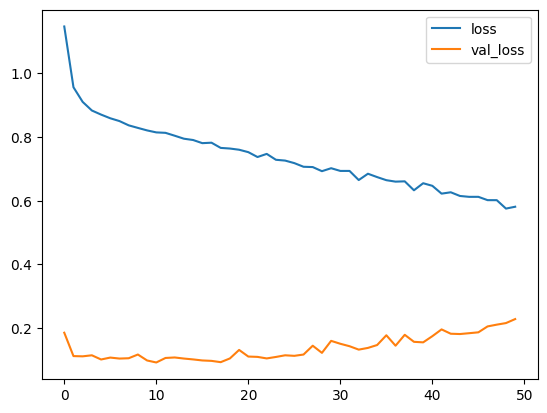

-0.3517308743647831

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
r2

# Data Augmentation

In [111]:
train,test=_load_data()

fake=pd.DataFrame([[1,2,3,4,5,6,7,8,9,10,11]],columns=train.columns,index=range(2000))
fake.columns
for item in fake.columns:
    fake[item]=np.random.random(2000)
fake['fake']=np.ones(len(fake))
fake

(605, 11) (461, 11)


,temperature,solids,dissolved_oxygen,pH,electrical,NH4,NO2,NO3,TN,PO4P,BOD5,fake
0,0.34,0.08,1.00,0.34,0.54,0.91,0.55,0.47,0.31,0.58,0.13,1.00
1,0.23,0.68,0.27,0.16,0.79,0.57,0.63,0.60,0.42,0.77,0.03,1.00
2,0.63,0.69,0.48,0.72,0.14,0.41,0.87,0.93,0.33,0.29,0.80,1.00
3,0.97,0.41,0.95,0.67,0.83,0.97,0.12,0.76,0.24,0.53,0.66,1.00
4,0.94,0.73,0.25,0.86,0.16,0.79,0.49,0.93,0.58,0.31,0.13,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.66,0.43,0.17,0.85,0.19,0.51,0.83,0.59,0.40,0.80,0.45,1.00
1996,0.23,0.20,0.17,0.39,0.59,0.37,0.46,0.86,0.81,0.24,0.94,1.00
1997,0.83,0.93,0.39,0.02,0.90,0.82,0.50,0.39,0.96,0.74,0.83,1.00
1998,0.67,0.87,0.52,0.64,0.44,0.17,0.54,0.57,0.45,0.57,0.22,1.00


In [112]:
train['fake']=np.zeros(len(train))
df=pd.concat([fake,train],axis=0)
df.reset_index(drop=True,inplace=True)
df

,temperature,solids,dissolved_oxygen,pH,electrical,NH4,NO2,NO3,TN,PO4P,BOD5,fake
0,0.34,0.08,1.00,0.34,0.54,0.91,0.55,0.47,0.31,0.58,0.13,1.00
1,0.23,0.68,0.27,0.16,0.79,0.57,0.63,0.60,0.42,0.77,0.03,1.00
2,0.63,0.69,0.48,0.72,0.14,0.41,0.87,0.93,0.33,0.29,0.80,1.00
3,0.97,0.41,0.95,0.67,0.83,0.97,0.12,0.76,0.24,0.53,0.66,1.00
4,0.94,0.73,0.25,0.86,0.16,0.79,0.49,0.93,0.58,0.31,0.13,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2600,24.60,22.00,7.70,8.25,1300.00,0.04,0.01,0.13,0.14,1.09,3.90,0.00
2601,22.40,8.00,3.60,8.00,1192.00,0.02,0.01,0.13,0.14,1.03,3.80,0.00
2602,14.50,11.00,6.90,8.36,1216.00,0.02,0.01,0.61,0.62,0.36,1.30,0.00
2603,10.80,3.00,8.60,8.35,1274.00,0.02,0.03,1.88,1.91,0.32,1.50,0.00


In [113]:
from imblearn.over_sampling import SMOTE
X=df.drop(['fake'],axis=1)
y=df.fake
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X['fake']=y
X

,temperature,solids,dissolved_oxygen,pH,electrical,NH4,NO2,NO3,TN,PO4P,BOD5,fake
0,0.34,0.08,1.00,0.34,0.54,0.91,0.55,0.47,0.31,0.58,0.13,1.00
1,0.23,0.68,0.27,0.16,0.79,0.57,0.63,0.60,0.42,0.77,0.03,1.00
2,0.63,0.69,0.48,0.72,0.14,0.41,0.87,0.93,0.33,0.29,0.80,1.00
3,0.97,0.41,0.95,0.67,0.83,0.97,0.12,0.76,0.24,0.53,0.66,1.00
4,0.94,0.73,0.25,0.86,0.16,0.79,0.49,0.93,0.58,0.31,0.13,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,21.31,23.31,6.21,7.99,340.77,0.04,0.02,0.47,0.49,0.08,1.61,0.00
3996,4.82,7.14,14.62,8.09,525.86,0.02,0.02,1.40,1.42,0.01,3.66,0.00
3997,3.38,31.36,12.68,8.30,1569.71,0.02,0.02,4.65,4.67,0.14,1.41,0.00
3998,2.18,3.30,11.97,7.93,560.24,0.13,0.03,1.54,1.57,0.09,2.02,0.00


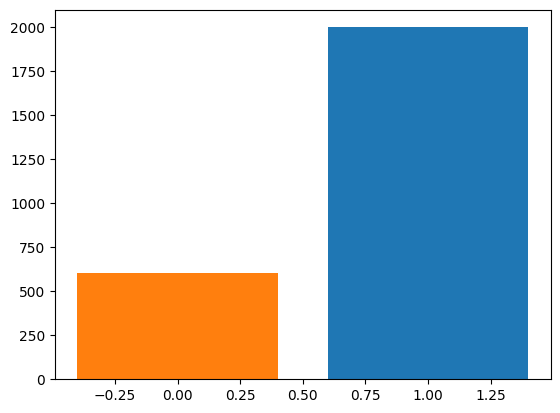

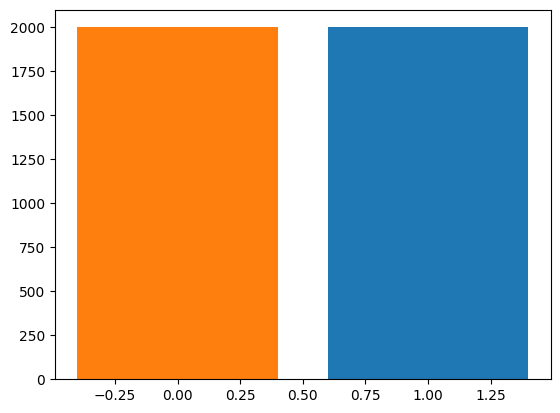

In [114]:
plt.bar(1,len(df[df.fake==1]))
plt.bar(0,len(df[df.fake==0]))
plt.show()
plt.bar(1,len(X[X.fake==1]))
plt.bar(0,len(X[X.fake==0]))
plt.show()

In [115]:
train=X[X.fake==0]
train.drop(['fake'],axis=1,inplace=True)
train

,temperature,solids,dissolved_oxygen,pH,electrical,NH4,NO2,NO3,TN,PO4P,BOD5
2000,3.20,26.00,10.80,7.90,465.00,0.07,0.02,1.12,1.14,0.10,1.60
2001,2.00,30.00,12.70,7.90,656.00,0.17,0.02,1.13,1.15,0.06,1.40
2002,6.60,41.00,11.80,8.10,746.00,0.10,0.02,1.54,1.56,0.04,1.40
2003,12.30,225.00,93.00,8.00,419.00,0.09,0.02,1.47,1.49,0.04,3.60
2004,17.80,35.00,10.70,8.40,492.00,0.04,0.02,0.64,0.66,0.02,1.90
...,...,...,...,...,...,...,...,...,...,...,...
3995,21.31,23.31,6.21,7.99,340.77,0.04,0.02,0.47,0.49,0.08,1.61
3996,4.82,7.14,14.62,8.09,525.86,0.02,0.02,1.40,1.42,0.01,3.66
3997,3.38,31.36,12.68,8.30,1569.71,0.02,0.02,4.65,4.67,0.14,1.41
3998,2.18,3.30,11.97,7.93,560.24,0.13,0.03,1.54,1.57,0.09,2.02


In [136]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()

# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(2000, 10) (2000, 1)


Epoch 1/100
250/250 [==============================] - 3s 6ms/step - loss: 0.9994 - val_loss: 1.1278
Epoch 2/100
250/250 [==============================] - 1s 6ms/step - loss: 0.9951 - val_loss: 1.1184
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.9709 - val_loss: 1.0715
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.8949 - val_loss: 0.9693
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.7905 - val_loss: 0.8740
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.7178 - val_loss: 0.8174
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6788 - val_loss: 0.7863
Epoch 8/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6592 - val_loss: 0.7720
Epoch 9/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6489 - val_loss: 0.7641
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6420 - val_lo

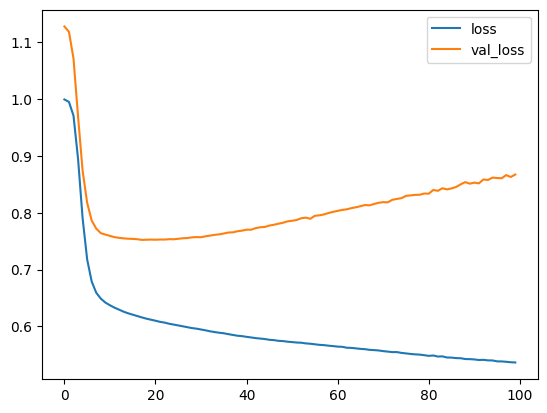

R_squared is: 0.23130847279757805


In [157]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train[0].shape[0],),kernel_initializer='normal', activation='relu'))
    model.add(Dense(15,kernel_initializer='normal', activation='relu'))
    model.add(Dense(5,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,kernel_initializer='normal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred

history , r2 , y_pred=_compile_model(X_train,y_train,X_test,y_test,100,8)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
print('R_squared is:',r2)

# Hybrid model

In [76]:
train , test =_load_data()

(605, 11) (461, 11)


In [116]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()

# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(2000, 10) (2000, 1)


In [117]:
def _create_NN_features():
    model = Sequential()
    model.add(Dense(40, input_shape=(X_train[0].shape[0],),kernel_initializer='normal', activation='relu'))
    model.add(Dense(30,kernel_initializer='normal', activation='relu'))
    model.add(Dense(20,kernel_initializer='normal', activation='relu'))
    model.add(Dense(10,kernel_initializer='normal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
    model.fit(X_train, y_train,epochs=40,batch_size=8,validation_split=0.2)
    nnfeatures=model.predict(X_train)
    return nnfeatures , model

In [118]:
df_train , model =_create_NN_features()
df_test=model.predict(X_test)

# df_train=X_scaler.transform(df_train)
# df_test=X_scaler.transform(df_test)


reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(df_train, df_test, y_train, y_test)

Epoch 1/40
200/200 [==============================] - 1s 4ms/step - loss: 1.1524 - val_loss: 0.3839
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 1.1324 - val_loss: 0.3318
Epoch 3/40
200/200 [==============================] - 1s 3ms/step - loss: 1.0340 - val_loss: 0.2214
Epoch 4/40
200/200 [==============================] - 1s 3ms/step - loss: 0.9507 - val_loss: 0.1742
Epoch 5/40
200/200 [==============================] - 0s 2ms/step - loss: 0.8982 - val_loss: 0.1410
Epoch 6/40
200/200 [==============================] - 1s 3ms/step - loss: 0.8612 - val_loss: 0.1211
Epoch 7/40
200/200 [==============================] - 0s 2ms/step - loss: 0.8351 - val_loss: 0.1085
Epoch 8/40
200/200 [==============================] - 0s 2ms/step - loss: 0.8184 - val_loss: 0.1029
Epoch 9/40
200/200 [==============================] - 0s 2ms/step - loss: 0.8056 - val_loss: 0.0984
Epoch 10/40
200/200 [==============================] - 1s 3ms/step - loss: 0.7945 - val_loss: 0.0962

100%|██████████| 42/42 [05:36<00:00,  8.01s/it]


In [119]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.34,0.35,0.85,0.29
NuSVR,0.33,0.35,0.85,0.37
HuberRegressor,0.27,0.28,0.89,0.31
LinearSVR,0.21,0.23,0.93,0.11
TweedieRegressor,0.18,0.19,0.95,0.19
HistGradientBoostingRegressor,0.15,0.17,0.96,1.18
ElasticNet,0.15,0.17,0.96,0.02
ElasticNetCV,0.14,0.16,0.97,0.41
SGDRegressor,0.14,0.16,0.97,0.08
